In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Input folders
RAW_DATA_DIR = "../data/raw/"
INTERIM_DATA_DIR = "../data/interim/"
PROCESSED_DATA_DIR = "../data/processed/"

In [7]:
df = pd.read_csv(f'{RAW_DATA_DIR}newdata_2014_2024.csv')
df.head(3)

,row_id,grower,farm,field,field_fvid,lat,lng,date,year,week,...,name_of_scout,param,count,value,edges,patches,tmin,tmax,gdd,cum_gdd
0,2,Alsum Farms,Alsum Farms Grand Marsh,Pines,1273426,43.972199,-89.605148,2024-09-03,2024,36,...,Tim Gross,"Beetle, Colorado potato - adults - Count per 2...",0.0,0.0,NaN,NaN,48.036263,75.547083,10.439880,1919.064835
1,2,Alsum Farms,Alsum Farms Grand Marsh,Pines,1273426,43.972199,-89.605148,2024-09-03,2024,36,...,Tim Gross,"Beetle, Colorado potato - larvae - Count per 2...",0.0,0.0,0.0,0.0,48.036263,75.547083,10.439880,1919.064835
2,4,Alsum Farms,Alsum Farms Arena,001,983803,43.173425,-89.977533,2024-08-26,2024,35,...,NaN,"Beetle, Colorado potato - adults - Count per 2...",1.0,1.0,NaN,NaN,70.101982,93.932563,28.001965,2035.133698


In [9]:
df.columns

Index(['row_id', 'grower', 'farm', 'field', 'field_fvid', 'lat', 'lng', 'date',
       'year', 'week', 'yday', 'name_of_scout', 'param', 'count', 'value',
       'edges', 'patches', 'tmin', 'tmax', 'gdd', 'cum_gdd'],
      dtype='object')

In [11]:
print(f"Original Data Shape:  {df.shape}")
print(f"Amount of Row_id:     {df['row_id'].nunique()}")
print(f"Unique Fields amount: {df['field_fvid'].nunique()}")
print(f"Years in the dataset: {np.sort(df['year'].unique().tolist())} ")

Original Data Shape:  (92578, 21)
Amount of Row_id:     39492
Unique Fields amount: 1853
Years in the dataset: [2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024] 


### Extracting abundance data (adults, larvaes & egg mass)

Restructure abundance data (adult, larvae, egg mass) currently within a single 'param' column.
group_id: Unique group identifier.
param: Specifies abundance type (adult, larva, egg mass).

We have created 6 new columns: `_count, _value

In [14]:
def process_row_id(group):
    first_row = group.iloc[0].copy()
    
    for param_type in ['adults', 'larvae', 'egg masses']:
        matching_row = group[group['param'].str.contains(param_type, case=False, na=False)]
        if not matching_row.empty:
            first_row[f'cpb{param_type[0]}_count'] = matching_row['count'].iloc[0]
            first_row[f'cpb{param_type[0]}_value'] = matching_row['value'].iloc[0]
        else:
            # If no data is available for this type, fill with NaN
            first_row[f'cpb{param_type[0]}_count'] = None
            first_row[f'cpb{param_type[0]}_value'] = None
    
    return first_row

final_data = df.groupby('row_id').apply(process_row_id)

final_data = final_data.reset_index(drop=True)

columns_to_drop = ['param', 'count', 'value', 'edges', 'patches']
final_data = final_data.drop(columns=columns_to_drop, errors='ignore')

print(final_data.shape)
print(final_data.head())

(39492, 22)
   row_id       grower                     farm   field  field_fvid  \
0       2  Alsum Farms  Alsum Farms Grand Marsh   Pines     1273426   
1       4  Alsum Farms        Alsum Farms Arena     001      983803   
2       8  Alsum Farms        Alsum Farms Arena     040      983811   
3      11  Alsum Farms  Alsum Farms Grand Marsh  Goggin      799043   
4      16  Alsum Farms  Alsum Farms Grand Marsh  Miller      799044   

         lat        lng        date  year  week  ...       tmin       tmax  \
0  43.972199 -89.605148  2024-09-03  2024    36  ...  48.036263  75.547083   
1  43.173425 -89.977533  2024-08-26  2024    35  ...  70.101982  93.932563   
2  43.165688 -89.945721  2024-08-26  2024    35  ...  70.025549  93.818913   
3  43.921085 -89.700531  2024-08-26  2024    35  ...  68.150575  95.022789   
4  43.941391 -89.647851  2024-08-20  2024    34  ...  45.230355  72.977558   

         gdd      cum_gdd  cpba_count  cpba_value  cpbl_count  cpbl_value  \
0  10.439880  1

/var/folders/zp/r3p5skms0k50v110tgsl6plw0000gn/T/ipykernel_49117/3919459024.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_data = df.groupby('row_id').apply(process_row_id)


### Frequency of Field Measurements per Year

We aim to determine how often the abundance rate was measured by a single field in one year and analyze the distribution of these measurement frequencies.

In [16]:
measurement_counts = final_data.groupby(['field_fvid', 'year']).size().reset_index(name='amount')

print(measurement_counts)

      field_fvid  year  amount
0          62992  2014      14
1          62992  2017      11
2          62992  2020      13
3          62992  2023      11
4          62995  2014       1
...          ...   ...     ...
3337     1274214  2024       9
3338     1274961  2024       7
3339     1274962  2024       5
3340     1275504  2024       9
3341     1276782  2024       9

[3342 rows x 3 columns]


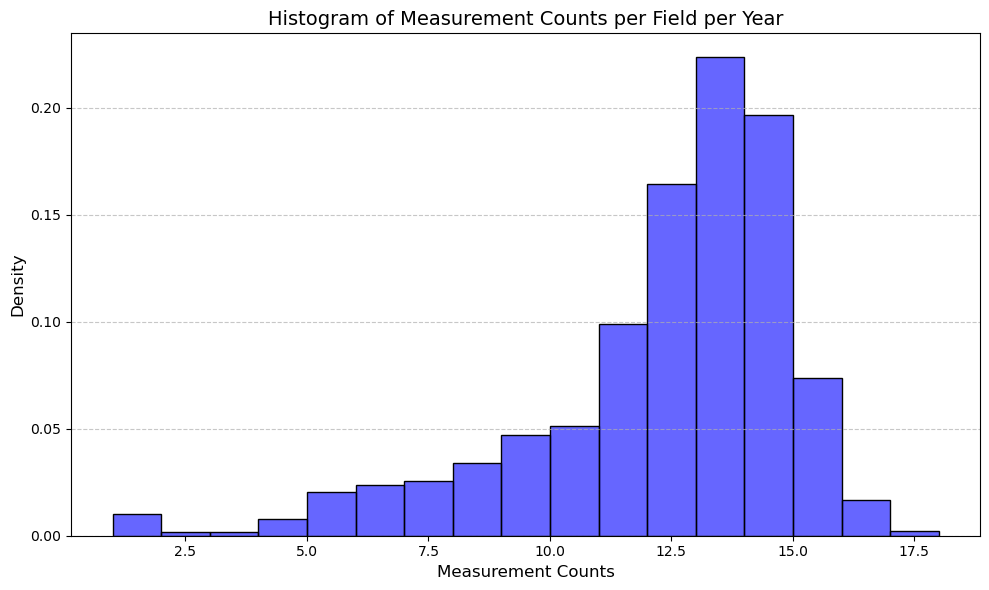

In [18]:
bins = range(1, measurement_counts['amount'].max() + 2) 

plt.figure(figsize=(10, 6))
sns.histplot(
    measurement_counts['amount'],
    bins=bins,
    kde=False,  
    color='blue',
    stat="density",
    alpha=0.6
)

plt.title("Histogram of Measurement Counts per Field per Year", fontsize=14)
plt.xlabel("Measurement Counts", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [20]:
measurement_counts["amount"].min()

1

### Annual Average Abundance Calculation

We calculated annual averages for abundance rates and climate data: tmin (minimum), tmax (maximum), gdd (average), and cum_gdd (latest value).

In [23]:
average_columns = [
    'gdd', 'cpba_count', 'cpba_value',
    'cpbl_count', 'cpbl_value'
]
min_max_columns = ['tmin', 'tmax']  # Specific min and max calculations
first_row_columns = [
    'grower', 'farm', 'field', 'field_fvid', 
    'lat', 'lng', 'year'
]

columns_to_drop = ['week', 'row_id', 'cpbe_count', 'cpbe_value']  # Retain 'yday' for sorting
final_data = final_data.drop(columns=columns_to_drop, errors='ignore')

final_data = final_data.sort_values(by=['year', 'field_fvid', 'yday'])

agg_dict = {col: 'mean' for col in average_columns} 
agg_dict.update({'cum_gdd': 'max'})  
agg_dict.update({'tmin': 'min'})  # Minimum temperature
agg_dict.update({'tmax': 'max'})  # Maximum temperature
agg_dict.update({col: 'first' for col in first_row_columns})  # Take first for identifiers

annual_data = final_data.groupby(['year', 'field_fvid'], as_index=False).agg(agg_dict)

ordered_columns = first_row_columns + min_max_columns + average_columns + ['cum_gdd']
annual_data = annual_data[ordered_columns]

print(annual_data.head())


                    grower farm           field  field_fvid        lat  \
0  Wisconsin Central Farms  WCF       1 Necedah       62992  44.057164   
1  Wisconsin Central Farms  WCF      12 Hollman       62995  44.202219   
2  Wisconsin Central Farms  WCF  13 Nepco N 1/2       62996  44.209406   
3  Wisconsin Central Farms  WCF      16 13th St       62999  44.100775   
4  Wisconsin Central Farms  WCF      26 Huebner       63009  44.171606   

         lng  year       tmin       tmax        gdd  cpba_count  cpba_value  \
0 -90.040412  2014  44.815974  83.173633  13.772113    3.307692    3.307692   
1 -90.021252  2014 -12.569807  13.704226   0.000000         NaN         NaN   
2 -90.021382  2014  45.498328  79.713370  12.804045    4.562500    4.500000   
3 -90.050524  2014  45.224964  82.761841  14.263578    1.637500    1.781818   
4 -89.975877  2014  45.584387  82.216665  13.292737    2.181818    2.000000   

   cpbl_count  cpbl_value      cum_gdd  
0    3.900000    3.900000  1727.895721 

In [25]:
print(annual_data.shape)

(3342, 15)


In [27]:
annual_data.to_csv(f"{INTERIM_DATA_DIR}/1_annual_averages.csv", index=False)

### Data Cleaning: Handling Missing Values and Unused Columns

We tested annual_data for missing values and found that several abundance records for adults and larvae were missing. Additionally, the eggs_mass column was removed as it is not used in further analysis.

In total, 11 rows were removed after cleaning.

In [30]:
print(annual_data.isnull().sum())

grower        0
farm          0
field         0
field_fvid    0
lat           0
lng           0
year          0
tmin          0
tmax          0
gdd           0
cpba_count    5
cpba_value    5
cpbl_count    8
cpbl_value    8
cum_gdd       0
dtype: int64


In [32]:
missed_columns = ['cpba_count', 'cpba_value', 'cpbl_count', 'cpbl_value']
df_filtered = annual_data.dropna(subset=missed_columns)

print(df_filtered.isnull().sum())
print(df_filtered.shape)

grower        0
farm          0
field         0
field_fvid    0
lat           0
lng           0
year          0
tmin          0
tmax          0
gdd           0
cpba_count    0
cpba_value    0
cpbl_count    0
cpbl_value    0
cum_gdd       0
dtype: int64
(3331, 15)


In [36]:
print(df_filtered.head())
df_filtered.to_csv(f"{INTERIM_DATA_DIR}2_nonmissing_annual_averages.csv", index=False)

                    grower farm           field  field_fvid        lat  \
0  Wisconsin Central Farms  WCF       1 Necedah       62992  44.057164   
2  Wisconsin Central Farms  WCF  13 Nepco N 1/2       62996  44.209406   
3  Wisconsin Central Farms  WCF      16 13th St       62999  44.100775   
4  Wisconsin Central Farms  WCF      26 Huebner       63009  44.171606   
5  Wisconsin Central Farms  WCF        7 N Home       63016  44.329762   

         lng  year       tmin       tmax        gdd  cpba_count  cpba_value  \
0 -90.040412  2014  44.815974  83.173633  13.772113    3.307692    3.307692   
2 -90.021382  2014  45.498328  79.713370  12.804045    4.562500    4.500000   
3 -90.050524  2014  45.224964  82.761841  14.263578    1.637500    1.781818   
4 -89.975877  2014  45.584387  82.216665  13.292737    2.181818    2.000000   
5 -89.931300  2014  45.715179  78.727568  12.237354    1.200000    1.200000   

   cpbl_count  cpbl_value      cum_gdd  
0    3.900000    3.900000  1727.895721 

In [38]:
df_filtered['field_fvid'].nunique()

1849

### Analysis of Adult and Larvae Abundance: count vs. value

We tested the distributions of adult and larvae abundance using the count and value measurements. From the density plots, we observed that their distributions look approximately similar.

Next, we plotted a line chart to visualize the annual trends for both count and value. The results indicate that the trends are also very similar across years, making it unclear which measurement (count or value) would be more suitable to use for analysis.

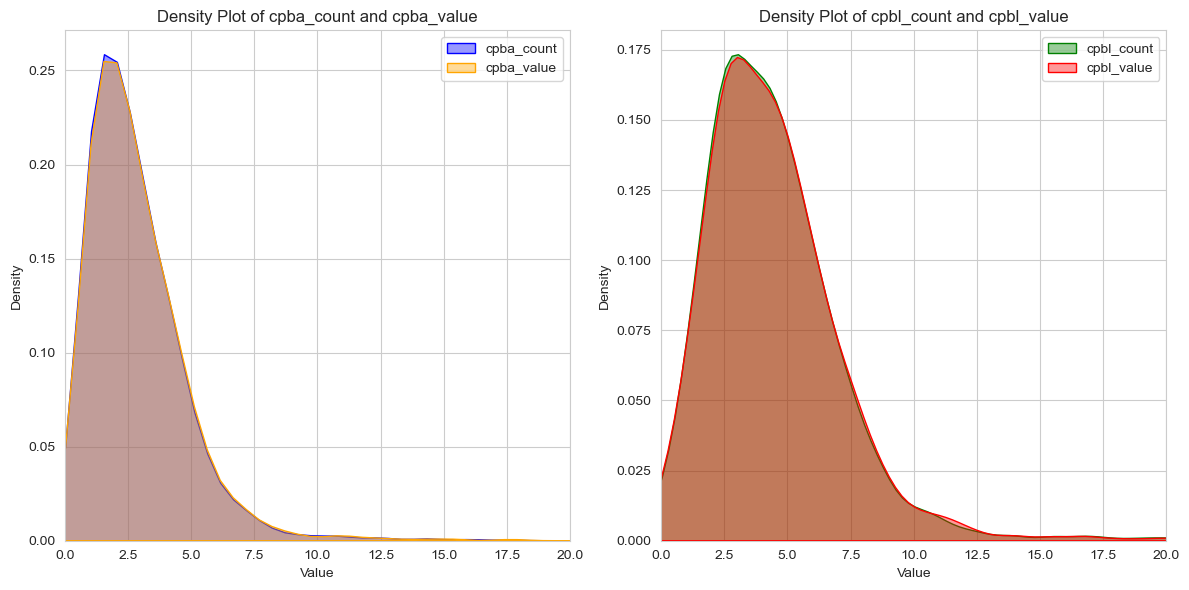

In [41]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_filtered, x='cpba_count', label='cpba_count', color='blue', fill=True, alpha=0.4)
sns.kdeplot(data=df_filtered, x='cpba_value', label='cpba_value', color='orange', fill=True, alpha=0.4)
plt.title("Density Plot of cpba_count and cpba_value")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim([0,20])
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(data=df_filtered, x='cpbl_count', label='cpbl_count', color='green', fill=True, alpha=0.4)
sns.kdeplot(data=df_filtered, x='cpbl_value', label='cpbl_value', color='red', fill=True, alpha=0.4)
plt.title("Density Plot of cpbl_count and cpbl_value")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim([0,20])
plt.legend()

plt.tight_layout()
plt.show()

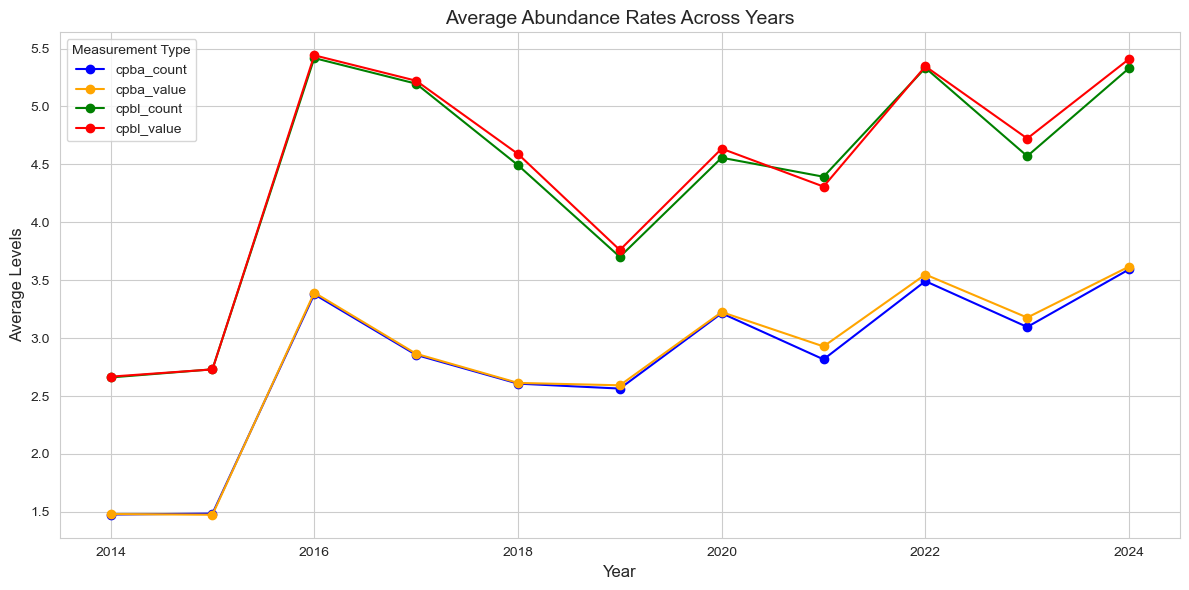

In [43]:
annual_avg = df_filtered.groupby('year').agg({
    'cpba_count': 'mean',
    'cpba_value': 'mean',
    'cpbl_count': 'mean',
    'cpbl_value': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))


plt.plot(annual_avg['year'], annual_avg['cpba_count'], label='cpba_count', color='blue', marker='o')
plt.plot(annual_avg['year'], annual_avg['cpba_value'], label='cpba_value', color='orange', marker='o')

plt.plot(annual_avg['year'], annual_avg['cpbl_count'], label='cpbl_count', color='green', marker='o')
plt.plot(annual_avg['year'], annual_avg['cpbl_value'], label='cpbl_value', color='red', marker='o')

plt.title("Average Abundance Rates Across Years", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Levels", fontsize=12)
plt.legend(title="Measurement Type", fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

## Next Steps

Next, we will calculate and extract the following variables:

1. **Crop type**: using CDL layer `.tif` files from [CropScape](https://nassgeodata.gmu.edu/CropScape/).  
   We have the center coordinates of each field. For each field location, we will extract the crop type from the corresponding CDL raster data to identify which crop was planted there.

2. **Potato proportion**:  
   We will compute two versions of potato proportion for each field:
   - **Weighted proportion**: using a linear weighting scheme (weights 5, 4, 3, 2, 1) over the current and last 5 years.
   - **Classical proportion**: calculating the simple average proportion (potato planted in the last 5 years divided by 5).

3. **Potato intensity**:  
   Using a 1500-meter buffer zone around each field, we will compute:
   - **Weighted potato intensity**  
   - **Classical potato intensity**  
   (Similar to the proportion calculation, but based on the spatial neighborhood.)

All of these calculations will be done in **R** because raster data processing is more efficient with available R packages — in particular using `library(terra)`.

After the new features are created in R, we will merge them back with the main dataset and save the result as a new dataset.

In the next Python script, we will add **climate data**, with a particular focus on **extreme weather variables**.


# Some plots (NEED to double check)

In [ ]:
final_data = pd.read_csv("../output_new_data/8P_final_with_climate_data.csv")
final_data.shape

In [ ]:
final_data.columns

In [ ]:
# Drop columns that are not useful for correlation analysis
cols_to_drop = ['grower', 'farm', 'field', 'field_fvid', 'lat', 'lng', 'year', 'cpba_value', 'cpbl_count', 'cpbl_value',]  # update as needed
# If your response variable is e.g. 'cpba_value', you can keep it for correlation analysis

# Select relevant columns (including response if you want)
corr_data = final_data.drop(columns=cols_to_drop)

# Optional: If you only want numeric columns
corr_data = corr_data.select_dtypes(include=[float, int])

# Compute correlation matrix
corr_matrix = corr_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features")
plt.show()

In [ ]:
yearly_summary = df_with_intensity.groupby('year').agg({
    'wei_intensity': 'mean',
    'clas_intensity': 'mean',
    'wei_prop': 'mean'
}).reset_index()

plt.figure(figsize=(12, 7))

plt.plot(yearly_summary['year'], yearly_summary['wei_intensity'], 
         label='Weigthed Intensity', color='blue', marker='o', linewidth=2)
plt.plot(yearly_summary['year'], yearly_summary['clas_intensity'], 
         label='Classic Intensity', color='orange', marker='o', linestyle='--', linewidth=2)
plt.plot(yearly_summary['year'], yearly_summary['wei_prop'], 
         label='Weigted Proportion', color='green', marker='o', linestyle='-.', linewidth=2)

plt.title("Intensity, 5-Year Intensity, and Potato Proportion Across Years", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
yearly_summary = df_with_intensity.groupby('year').agg({
    'intensity': 'mean',
    'intensity_5y': 'mean',
    'potato_proportion': 'mean',
    'cpba_count': 'mean'  # Add cpba_count for the secondary axis
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Intensity, 5-Year Intensity, and Potato Proportion (Left Y-Axis)
ax1.plot(yearly_summary['year'], yearly_summary['intensity'], 
         label='Intensity', color='blue', marker='o', linewidth=2)
ax1.plot(yearly_summary['year'], yearly_summary['intensity_5y'], 
         label='5-Year Intensity', color='orange', marker='o', linestyle='--', linewidth=2)
ax1.plot(yearly_summary['year'], yearly_summary['potato_proportion'], 
         label='Potato Proportion', color='green', marker='o', linestyle='-.', linewidth=2)

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Intensity / Proportion", fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

ax2 = ax1.twinx()  # Create a secondary Y-axis
ax2.plot(yearly_summary['year'], yearly_summary['cpba_count'], 
         label='CPBA Count', color='red', marker='s', linewidth=2)
ax2.set_ylabel("CPBA Count", fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

plt.title("Intensity, 5-Year Intensity, Potato Proportion, and CPBA Count Across Years", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
yearly_summary = df_with_intensity.groupby('year').agg({
    'tmin': 'mean',
    'tmax': 'mean',
    'gdd': 'mean',
    'cpba_count': 'mean',  # For secondary axis
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(yearly_summary['year'], yearly_summary['tmin'], 
         label='TMIN', color='blue', marker='o', linewidth=2)
ax1.plot(yearly_summary['year'], yearly_summary['tmax'], 
         label='TMAX', color='orange', marker='o', linestyle='--', linewidth=2)
ax1.plot(yearly_summary['year'], yearly_summary['gdd'], 
         label='GDD', color='green', marker='o', linestyle='-.', linewidth=2)

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Climate Data (TMIN, TMAX, GDD)", fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

ax2 = ax1.twinx()  # Create a secondary Y-axis
ax2.plot(yearly_summary['year'], yearly_summary['cpba_count'], 
         label='CPBA Count', color='red', marker='s', linewidth=2)
ax2.set_ylabel("CPBA Count", fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

plt.title("Climate Data (TMIN, TMAX, GDD) and CPBA Count Across Years", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
yearly_summary = df_with_intensity.groupby('year').agg({
    'gdd': 'mean',
    'cum_gdd': 'mean'
}).reset_index()

fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(yearly_summary['year'], yearly_summary['gdd'], 
        label='GDD', color='green', marker='o', linestyle='-.', linewidth=2)
ax.plot(yearly_summary['year'], yearly_summary['cum_gdd'], 
        label='Cumulative GDD', color='blue', marker='s', linewidth=2)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Values", fontsize=12)
ax.set_title("GDD and Cumulative GDD Across Years", fontsize=14)
ax.grid(True)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()